In [1]:
import atmospy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

# disable warnings for demo purposes
warnings.filterwarnings("ignore")

atmospy.set_theme()

# this tutorial was completed using version:
atmospy.__version__

'0.1.2'

In [2]:
# Initialize an empty DataFrame
df_lcs = pd.DataFrame()

# Define the start and end months and years
start_month = 5
start_year = 2024
end_month = 7
end_year = 2024

# Function to generate month-year strings
def generate_month_year_strings(start_month, start_year, end_month, end_year):
    month_year_list = []
    year = start_year
    month = start_month
    while year < end_year or (year == end_year and month <= end_month):
        month_year_list.append(f"{year}_{str(month).zfill(2)}")
        month += 1
        if month > 12:
            month = 1
            year += 1
    return month_year_list

# Generate the list of month-year strings
month_year_strings = generate_month_year_strings(start_month, start_year, end_month, end_year)

# Loop through each month-year string and load the CSV files
for month_year_string in month_year_strings:
    year, month = month_year_string.split('_')
    filename_tail = f"@devnode_{year}-{month}.csv"
    directory = os.path.join("lcs_data", month_year_string)

    df_co = pd.read_csv(os.path.join(directory, f"raw_CO-B4{filename_tail}"), sep=',')
    df_pm_opcn3 = pd.read_csv(os.path.join(directory, f"raw_PM-OPCN3{filename_tail}"), sep=',')
    df_pm_sps30 = pd.read_csv(os.path.join(directory, f"raw_PM-SPS30{filename_tail}"), sep=',')
    df_trh = pd.read_csv(os.path.join(directory, f"raw_T_RH_P_BME280{filename_tail}"), sep=',')
    
    # Combining all datasets using the "Čas" column
    df_temp = pd.merge(df_co, df_trh, on="Čas")
    # df_temp = pd.merge(df_temp, df_no2, on="Čas")
    # df_temp = pd.merge(df_temp, df_ox, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_opcn3, on="Čas")
    df_temp = pd.merge(df_temp, df_pm_sps30, on="Čas")
    
    # Calculating actual values for the WE (working electrode) and AE (auxiliary electrode) values
    df_temp["CO"] = df_temp["WE_CO"] - df_temp["AE_CO"]
    # df_temp["NH3"] = df_temp["WE_NH3"] - df_temp["AE_NH3"]
    # df_temp["NO2"] = df_temp["WE_NO2"] - df_temp["AE_NO2"]
    # df_temp["O3"] = df_temp["WE_O3"] - df_temp["AE_O3"]
      
    # Dropping the extra columns (including the pressure - that makes a negligible difference)
    df_temp = df_temp.drop(["WE_CO", "AE_CO", "PM_4"], axis=1)
    
    # Renaming the "Čas" column
    df_temp = df_temp.rename(columns={'Čas': 'Time'})
    
    # Converting the time to a datetime
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    
    # 1h shift of the CSV data (CSV seems to be UTC+1, reference data UTC)
    df_temp['Time'] += pd.Timedelta(hours=1)
    
    # Set 'Time' column as the DataFrame index
    df_temp.set_index('Time', inplace=True)
    
    # Resample to 1-hour intervals and calculate the mean for each group
    df_temp_1h = df_temp.resample('1h').mean()
    
    # Assign the calculated hourly means back to the original DataFrame
    df_temp = df_temp_1h.reset_index()
    
    # Append the data to the main DataFrame
    df_lcs = pd.concat([df_lcs, df_temp], ignore_index=True)

# Renaming the "Time" column to "GMT"
df_lcs = df_lcs.rename(columns={'Time': 'GMT'})

# Set 'GMT' column as the DataFrame index
df_lcs.set_index('GMT', inplace=True)

# Print the data types of the final DataFrame
print(df_lcs.dtypes)

T          float64
RH         float64
p          float64
PM_1_x     float64
PM_2.5     float64
PM_10_x    float64
PM_1_y     float64
PM_2       float64
PM_10_y    float64
CO         float64
dtype: object


In [3]:
# The edited dataset has the "Celkem" values at the end of the data removed
#df_ref = pd.read_excel(month_year_string + "/MS_MarianskeHory_60min_" + month_year_string + "_edited.xlsx")
df_ref = pd.DataFrame()

#df_ref = pd.read_csv('gmt_data/Nov-Feb_GMT_MarHory.csv', sep=';')
df_ref = pd.read_csv('gmt_data/Mar-Jul_GMT_MarHory.csv', sep=';')

#df_ref = df_ref.rename(columns={
#        'Unnamed: 0': 'Time',
#        'Celaskon; 1663_MarHory; WSPE [m/s]': 'WSPE [m/s]',
#        'Celaskon; 1663_MarHory; WDIR [deg]': 'WDIR [deg]',
#        'Celaskon; 1663_MarHory; HUMI [%]': 'HUMI [%]',
#        'Celaskon; 1663_MarHory; PRES [hPa]': 'PRES [hPa]',
#        'Celaskon; 1663_MarHory; TEMP [°C]': 'TEMP [°C]',
#        'Celaskon; 1663_MarHory; PM10 [ug/m3]': 'PM10 [µg/m3]',
#        'Celaskon; 1663_MarHory; O3 [ug/m3]': 'O3 [µg/m3]',
#        'Celaskon; 1663_MarHory; SO2 [ug/m3]': 'SO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; NO [ug/m3]': 'NO [µg/m3]',
#        'Celaskon; 1663_MarHory; NO2 [ug/m3]': 'NO2 [µg/m3]',
#        'Celaskon; 1663_MarHory; CO [ug/m3]': 'CO [µg/m3]'
#})

#Apply the function to the entire column
df_ref['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_ref['GMT'] = df_ref['GMT'].dt.tz_localize('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_ref = df_ref.drop(["TIME"], axis=1)

# Pokud potřebujete změnit pouze určité sloupce, můžete specifikovat sloupce takto:

df_ref[['WDIR [deg]', 
        'HUMI [%]', 
        'PRES [hPa]', 
        'TEMP [°C]', 
        'PM10 [ug/m3]', 
        'PM25 [ug/m3]', 
        'PM01 [ug/m3]', 
        'O3 [ug/m3]', 
        'SO2 [ug/m3]', 
        'NO [ug/m3]', 
        'NO2 [ug/m3]', 
        'CO [ug/m3]']] = df_ref[['WDIR [deg]', 
                                 'HUMI [%]', 
                                 'PRES [hPa]', 
                                 'TEMP [°C]', 
                                 'PM10 [ug/m3]', 
                                 'PM25 [ug/m3]', 
                                 'PM01 [ug/m3]', 
                                 'O3 [ug/m3]', 
                                 'SO2 [ug/m3]', 
                                 'NO [ug/m3]', 
                                 'NO2 [ug/m3]', 
                                 'CO [ug/m3]']].astype('float64')

#df_ref.head()
#print(df_ref.describe())
print(df_ref.dtypes)

GMT             datetime64[ns, UTC]
WSPE [m/s]                  float64
WDIR [deg]                  float64
HUMI [%]                    float64
PRES [hPa]                  float64
TEMP [°C]                   float64
PM10 [ug/m3]                float64
PM25 [ug/m3]                float64
PM01 [ug/m3]                float64
O3 [ug/m3]                  float64
SO2 [ug/m3]                 float64
NO [ug/m3]                  float64
NO2 [ug/m3]                 float64
CO [ug/m3]                  float64
dtype: object


In [4]:
df_cams = pd.DataFrame()

df_cams = pd.read_csv('gmt_data/Mar-Jul_gmt_CAMS-EUR.csv', sep=';')

df_cams['GMT'] = pd.to_datetime(df_ref['GMT'])

#Synchronizing the datatypes of "Time" in the datasets
df_cams['GMT'] = df_cams['GMT'].dt.tz_convert('UTC')

# Dropping the extra columns (including the pressure - that makes a negligible difference)
df_cams = df_cams.drop(["gmt"], axis=1)

#df_ref.head()
#print(df_ref.describe())
print(df_cams.dtypes)

pm10 (μg/m³)                            float64
pm2_5 (μg/m³)                           float64
carbon_monoxide (μg/m³)                 float64
nitrogen_dioxide (μg/m³)                float64
sulphur_dioxide (μg/m³)                 float64
ozone (μg/m³)                           float64
dust (μg/m³)                            float64
uv_index ()                             float64
ammonia (μg/m³)                         float64
GMT                         datetime64[ns, UTC]
dtype: object


In [5]:
# Merge the two DataFrames on the 'Time' column
df = pd.merge(df_lcs, df_ref, on='GMT')
df = pd.merge(df, df_cams, on='GMT')
# Sorting the values by the "Time" attribute
df.sort_values(by="GMT")
# Check the correlation between 'CO' and 'CO [µg/m3]'
#correlation = df_merged['CO'].diff().corr(df_merged['CO [ug/m3]'].diff())
#print(f'Correlation between CO and CO [µg/m3]: {correlation}')

,GMT,T,RH,p,PM_1_x,PM_2.5,PM_10_x,PM_1_y,PM_2,PM_10_y,...,CO [ug/m3],pm10 (μg/m³),pm2_5 (μg/m³),carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),ammonia (μg/m³)
0,2024-05-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,8.1,6.2,196.0,4.7,2.1,67.0,0.0,NaN,5.2
1,2024-05-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,8.1,6.2,184.0,4.9,2.3,61.0,0.0,NaN,5.0
2,2024-05-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,230.1,8.6,6.5,192.0,5.5,2.4,58.0,0.0,NaN,5.2
3,2024-05-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,277.9,10.9,7.6,223.0,9.7,2.8,49.0,0.0,NaN,6.3
4,2024-05-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,268.0,12.8,10.0,235.0,16.4,4.0,45.0,0.0,NaN,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,2024-07-31 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,10.3,8.5,191.0,9.6,1.2,89.0,0.0,NaN,3.7
2203,2024-07-31 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,11.8,9.5,211.0,12.9,1.4,72.0,0.0,NaN,3.9
2204,2024-07-31 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.0,12.8,9.1,210.0,14.1,1.4,69.0,0.0,NaN,4.2
2205,2024-07-31 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,203.1,14.4,12.2,211.0,14.1,1.4,61.0,0.0,NaN,4.8


In [6]:
#df.head()
#print(df.describe())
#print(df.dtypes)
#df.tail()

In [7]:
start_date = '2024-05-26'
end_date = '2024-07-09'

# Filter the DataFrame
sel_df = df[df['GMT'] >= start_date]
sel_df = sel_df[sel_df['GMT'] <= end_date]

# Sorting the values by the "GMT" attribute
df = sel_df.sort_values(by="GMT")

#df.head()
print(df[['TEMP [°C]','HUMI [%]','PRES [hPa]']].describe())

         TEMP [°C]     HUMI [%]   PRES [hPa]
count  1053.000000  1053.000000  1053.000000
mean     16.347104    76.222222   924.633428
std       4.664530    19.166421     5.446465
min       4.500000    32.000000   911.000000
25%      12.900000    59.000000   921.000000
50%      15.800000    81.000000   925.000000
75%      19.600000    96.000000   929.000000
max      28.600000    96.000000   938.000000


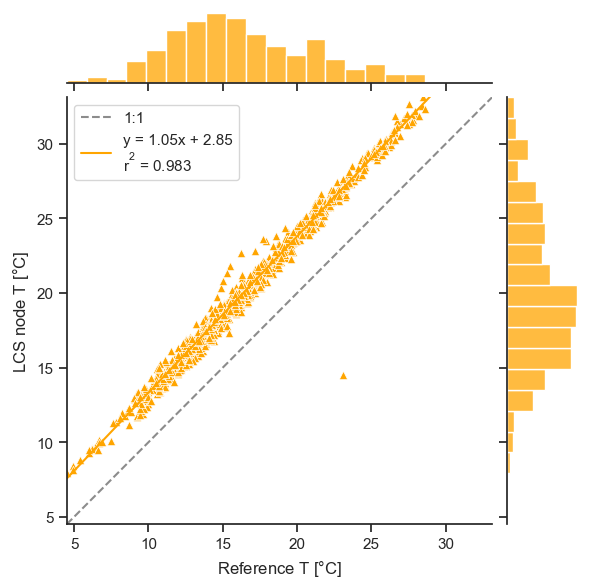

In [8]:
t = atmospy.regplot(
    data=df,
    x="TEMP [°C]", 
    y="T",
    color="orange",
    marker='^',
#    fit_reg=False
)
t.set_axis_labels(xlabel="Reference $T$ [$°C$]", ylabel="LCS node $T$ [$°C$]")

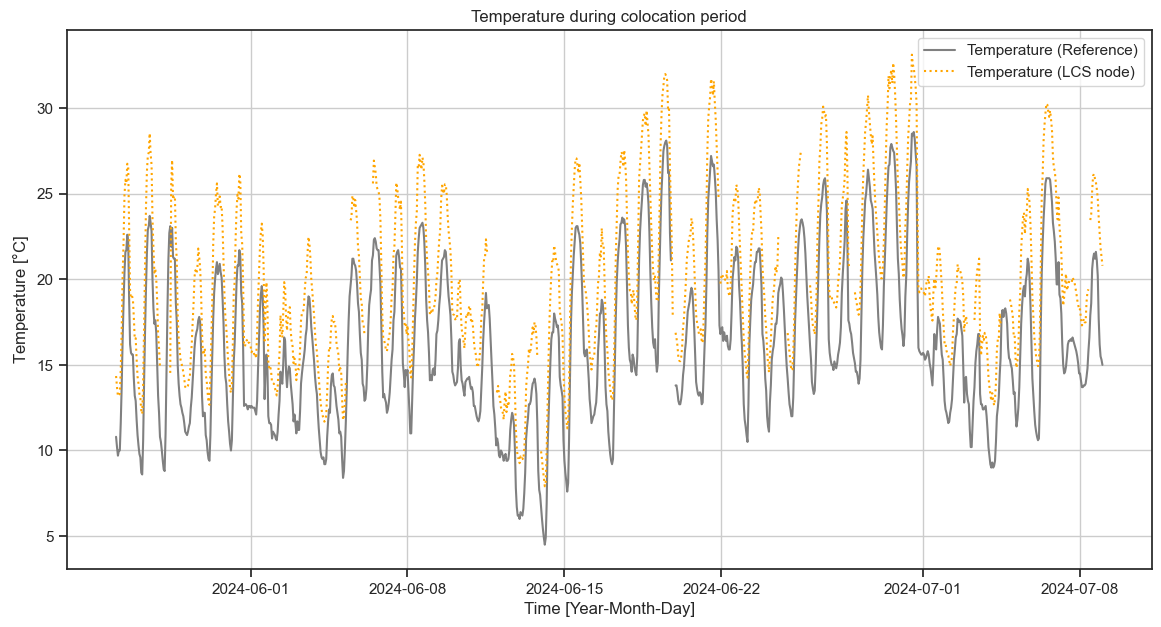

In [9]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['TEMP [°C]'],  color="grey",label='Temperature (Reference)')
plt.plot(df['GMT'], df['T'], color="orange", linestyle=":", label='Temperature (LCS node)')

plt.title('Temperature during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('Temperature [$°C$]')
plt.legend()
plt.grid(True)
plt.show()

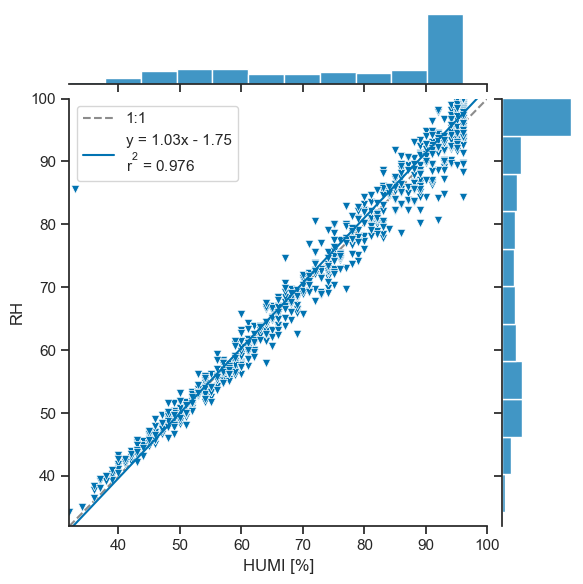

In [10]:
rh = atmospy.regplot(
    data=df,
    x="HUMI [%]", 
    y="RH",
    color="b",
    marker='v',
#    fit_reg=False
)
t.set_axis_labels(xlabel="Reference $RH$ [$\%$]", ylabel="LCS node $RH$ [$\%$]")

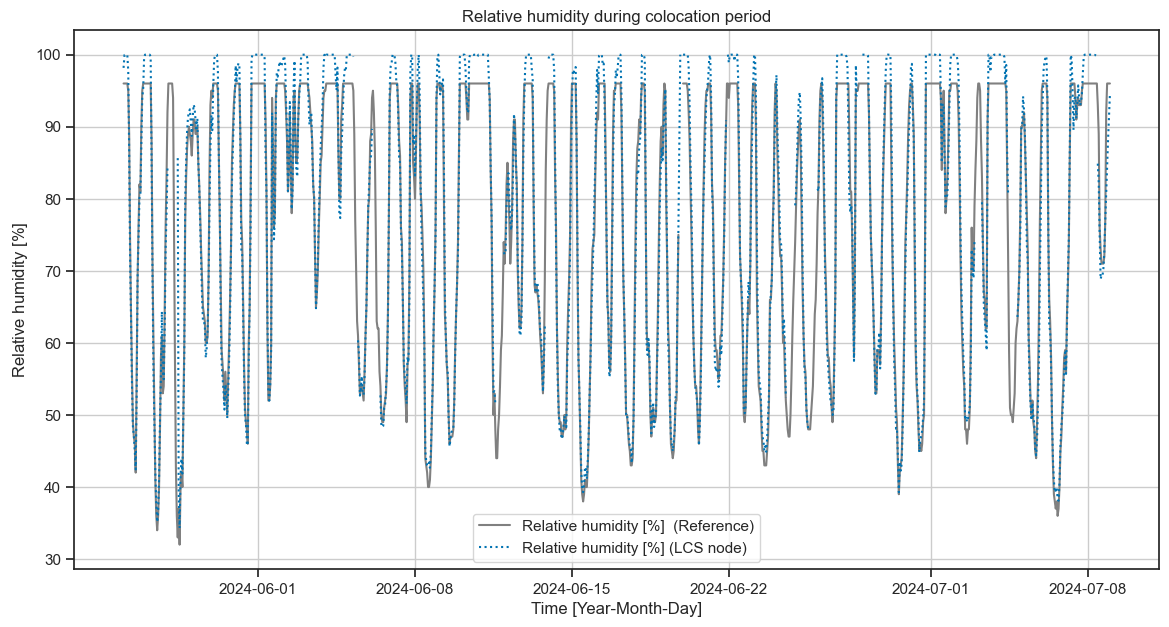

In [11]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['HUMI [%]'],  color="grey",label='Relative humidity [%]  (Reference)')
plt.plot(df['GMT'], df['RH'], color="b", linestyle=":", label='Relative humidity [%] (LCS node)')

plt.title('Relative humidity during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('Relative humidity [$\%$]')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
df["T"] = pd.to_numeric(df["T"], errors='coerce') + 273.15
df["CO"] = pd.to_numeric(df["CO"], errors='coerce') * 4394 + (-0.693)* pd.to_numeric(df["T"], errors='coerce')
df["CO [ug/m3]"] = pd.to_numeric(df["CO [ug/m3]"], errors='coerce')

df_filter = df[df["CO [ug/m3]"] > 200]
df_subfilter = df_filter[df_filter["CO [ug/m3]"] < 400]

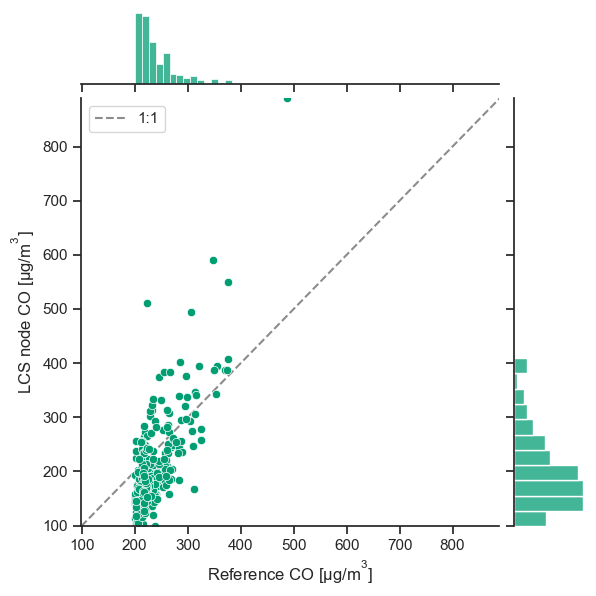

In [27]:
co = atmospy.regplot(
#    data=df,
    data=df_filter,
#    data=df_subfilter,
    x="CO [ug/m3]", 
    y="CO",
    color="g",
    marker='o',
    fit_reg=False
)
co.set_axis_labels(xlabel="Reference $CO$ [$µg/m^{3}$]", ylabel="LCS node $CO$ [$µg/m^{3}$]")

co = atmospy.regplot(
#   data=df,
     data=df_filter,
#    data=df_subfilter,
    x="CO [ug/m3]", 
    y="carbon_monoxide (μg/m³)",
    color="g",
    marker='x',
    fit_reg=False
)
co.set_axis_labels(xlabel="Reference $CO$ [$µg/m^{3}$]", ylabel="CAMS model $CO$ [$µg/m^{3}$]")

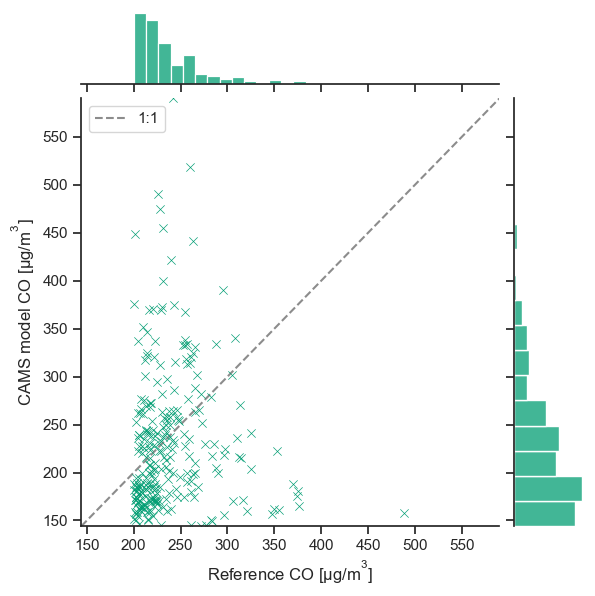

In [26]:
co = atmospy.regplot(
#   data=df,
     data=df_filter,
#    data=df_subfilter,
    x="CO [ug/m3]", 
    y="carbon_monoxide (μg/m³)",
    color="g",
    marker='x',
    fit_reg=False
)
co.set_axis_labels(xlabel="Reference $CO$ [$µg/m^{3}$]", ylabel="CAMS model $CO$ [$µg/m^{3}$]")

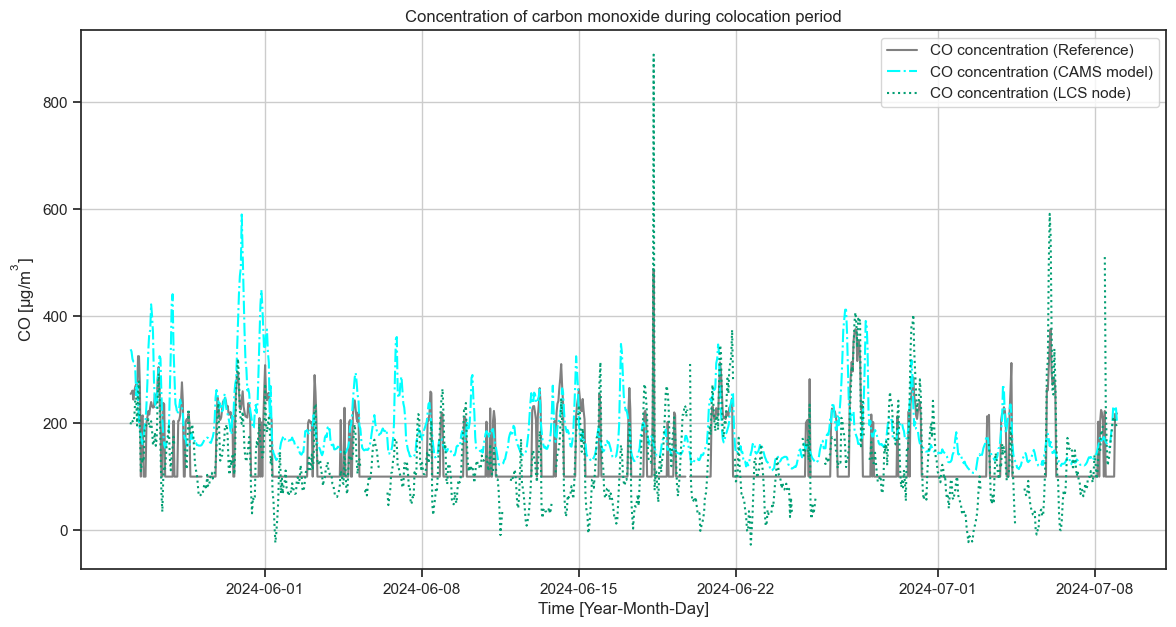

In [15]:
# Plotting
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['CO [ug/m3]'],  color="grey",label='CO concentration (Reference)')
plt.plot(df['GMT'], df['carbon_monoxide (μg/m³)'], color="cyan", linestyle="dashdot", label='CO concentration (CAMS model)')
plt.plot(df['GMT'], df['CO'], color="g", linestyle="dotted", label='CO concentration (LCS node)')

plt.title('Concentration of carbon monoxide during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('CO [$µg/m^3$]')
plt.legend()
plt.grid(True)
plt.show()

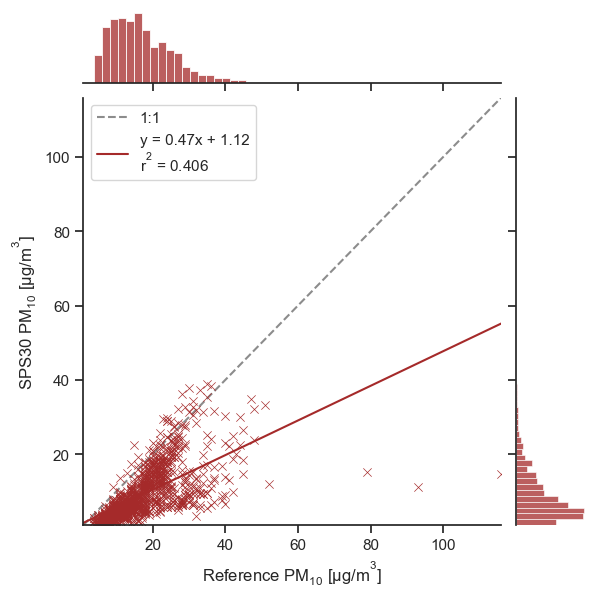

In [16]:
df["PM_10_y"] = pd.to_numeric(df["PM_10_y"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM10 [ug/m3]", 
    y="PM_10_y",   
    color="brown",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{10}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{10}$ [$µg/m^{3}$]")

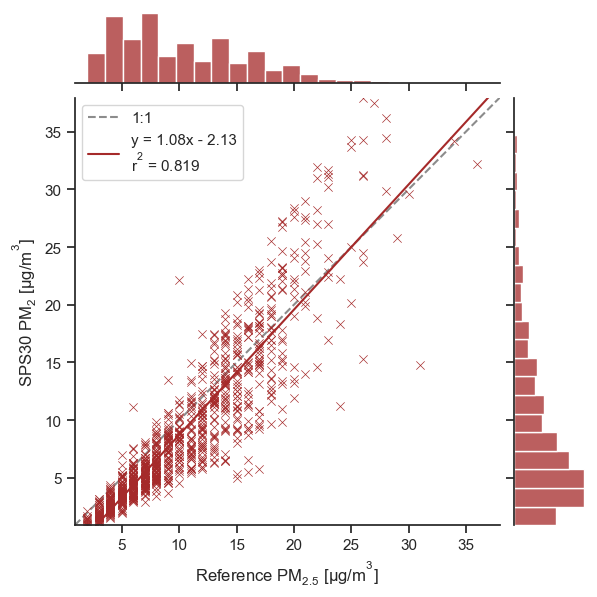

In [17]:
df["PM_2"] = pd.to_numeric(df["PM_2"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM25 [ug/m3]", 
    y="PM_2",   
    color="brown",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{2.5}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{2}$ [$µg/m^{3}$]")

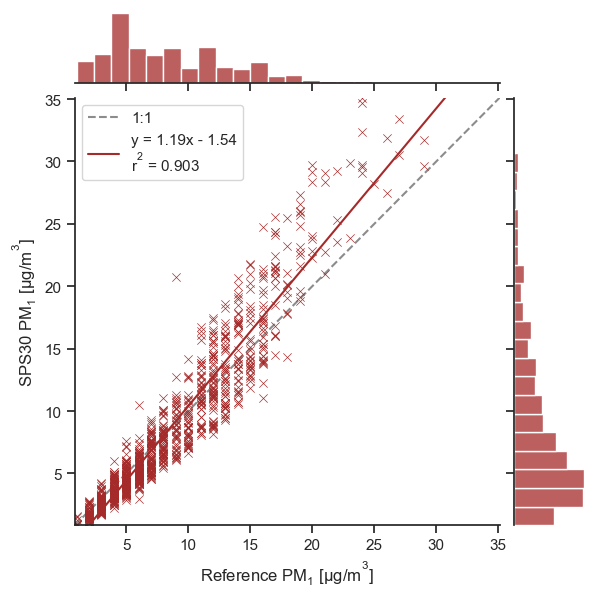

In [18]:
df["PM_1_y"] = pd.to_numeric(df["PM_1_y"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM01 [ug/m3]", 
    y="PM_1_y",   
    color="brown",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{1}$ [$µg/m^{3}$]", ylabel="SPS30 $PM_{1}$ [$µg/m^{3}$]")

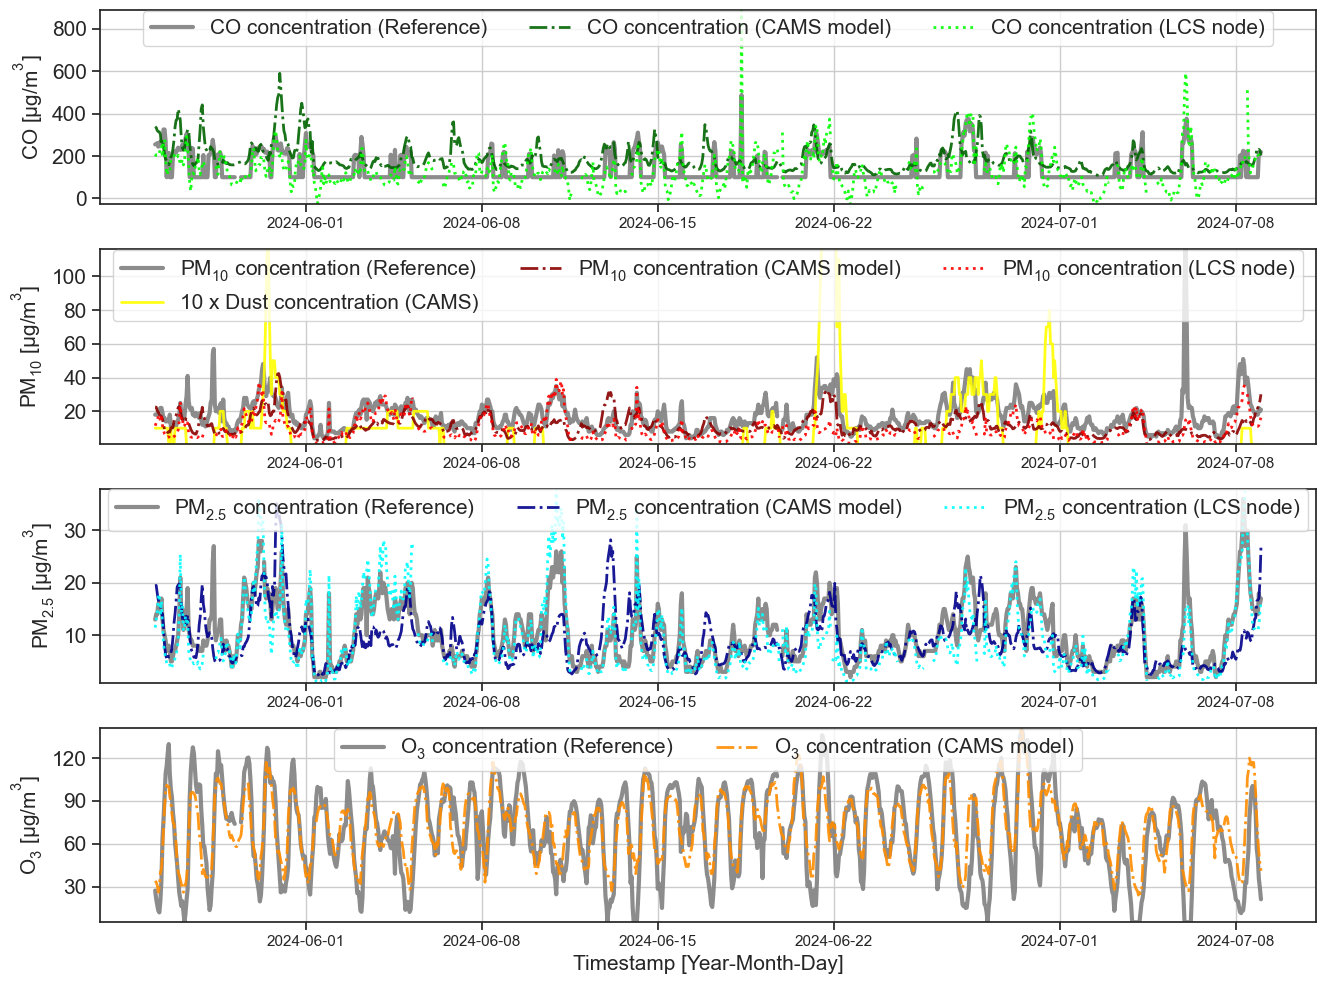

In [49]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with adjusted height
fig, axs = plt.subplots(4, 1, figsize=(14, 10))  # 4 rows, 1 column, reduced height

# Define the y-axis limits for CO
y_min = min(df['CO [ug/m3]'].min(), df['carbon_monoxide (μg/m³)'].min(), df['CO'].min())
y_max = max(df['CO [ug/m3]'].max(), df['carbon_monoxide (μg/m³)'].max(), df['CO'].max())

# First subplot
axs[0].plot(df['GMT'], df['CO [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='CO concentration (Reference)')
axs[0].plot(df['GMT'], df['carbon_monoxide (μg/m³)'], color="darkgreen", linestyle="dashdot", linewidth=2, alpha=0.9, label='CO concentration (CAMS model)')
axs[0].plot(df['GMT'], df['CO'], color="lime", linestyle="dotted", linewidth=2, alpha=0.9,  label='CO concentration (LCS node)')
axs[0].set_ylabel('CO [$µg/m^3$]', fontsize=15)
axs[0].grid(True)
axs[0].set_ylim(y_min, y_max)
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(200))  # Adjust interval as needed
axs[0].tick_params(axis='y', labelsize=15)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for PM10
y_min = min(df['PM10 [ug/m3]'].min(), df['pm10 (μg/m³)'].min(), df['PM_10_y'].min())
y_max = max(df['PM10 [ug/m3]'].max(), df['pm10 (μg/m³)'].max(), df['PM_10_y'].max())

# Second subplot
axs[1].plot(df['GMT'], df['PM10 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$PM_{10}$ concentration (Reference)')
axs[1].plot(df['GMT'], df['dust (μg/m³)']*10, color="yellow", linestyle="solid", linewidth=2, alpha=0.9, label='10 x Dust concentration (CAMS)')
axs[1].plot(df['GMT'], df['pm10 (μg/m³)'], color="darkred", linestyle="dashdot", linewidth=2, alpha=0.9, label='$PM_{10}$ concentration (CAMS model)')
axs[1].plot(df['GMT'], df['PM_10_y'], color="red", linestyle="dotted", linewidth=2, alpha=0.9,  label='$PM_{10}$ concentration (LCS node)')
axs[1].set_ylabel('$PM_{10}$ [$µg/m^3$]', fontsize=15)
axs[1].grid(True)
axs[1].set_ylim(y_min, y_max)
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(20))  # Adjust interval as needed
axs[1].tick_params(axis='y', labelsize=15)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for PM2.5
y_min = min(df['PM25 [ug/m3]'].min(), df['pm2_5 (μg/m³)'].min(), df['PM_2'].min())
y_max = max(df['PM25 [ug/m3]'].max(), df['pm2_5 (μg/m³)'].max(), df['PM_2'].max())

# Third subplot
axs[2].plot(df['GMT'], df['PM25 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$PM_{2.5}$ concentration (Reference)')
axs[2].plot(df['GMT'], df['pm2_5 (μg/m³)'], color="darkblue", linestyle="dashdot", linewidth=2, alpha=0.9, label='$PM_{2.5}$ concentration (CAMS model)')
axs[2].plot(df['GMT'], df['PM_2'], color="cyan", linestyle="dotted", linewidth=2, alpha=0.9,  label='$PM_{2.5}$ concentration (LCS node)')
axs[2].set_ylabel('$PM_{2.5}$ [$µg/m^3$]', fontsize=15)
axs[2].grid(True)
axs[2].set_ylim(y_min, y_max)
axs[2].yaxis.set_major_locator(ticker.MultipleLocator(10))  # Adjust interval as needed
axs[2].tick_params(axis='y', labelsize=15)
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05 * y_max / y_max), ncol=3, fontsize=15)

# Define the y-axis limits for O3
y_min = min(df['O3 [ug/m3]'].min(), df['ozone (μg/m³)'].min())
y_max = max(df['O3 [ug/m3]'].max(), df['ozone (μg/m³)'].max())

# Fourth subplot
axs[3].plot(df['GMT'], df['O3 [ug/m3]'], color="grey", linestyle="solid", linewidth=3, alpha=0.9, label='$O_3$ concentration (Reference)')
axs[3].plot(df['GMT'], df['ozone (μg/m³)'], color="darkorange", linestyle="dashdot", linewidth=2, alpha=0.9, label='$O_3$ concentration (CAMS model)')
axs[3].set_ylabel('$O_3$ [$µg/m^3$]', fontsize=15)
axs[3].set_xlabel('Timestamp [Year-Month-Day]', fontsize=15)
axs[3].grid(True)
axs[3].set_ylim(y_min, y_max)
axs[3].yaxis.set_major_locator(ticker.MultipleLocator(30))  # Adjust interval as needed
axs[3].tick_params(axis='y', labelsize=15)
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05 * y_max / y_max), ncol=3, fontsize=15)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: ylabel='$O_3 \\; [μg/m³]$'>

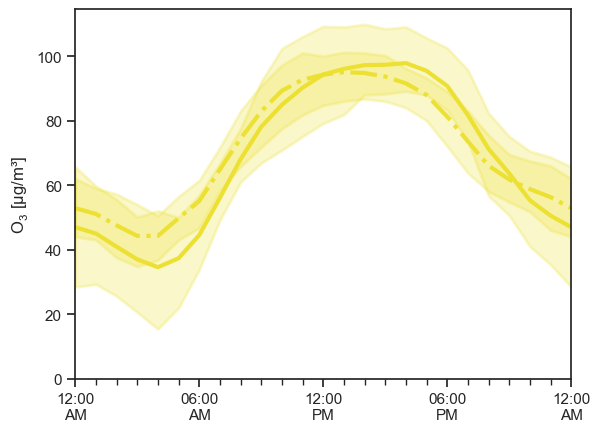

In [21]:
# Plot the diel trend
atmospy.dielplot(data=df,
    y="O3 [ug/m3]", x="GMT",
#    y='ozone (μg/m³)', x="GMT",
    ylabel="$O_3 \; [ppm]$",
    plot_kws={"c": "y", "linestyle": "solid"},
    ylim=(0, None))

atmospy.dielplot(data=df,
#    y="O3 [ug/m3]", x="GMT",
    y='ozone (μg/m³)', x="GMT",
    ylabel="$O_3 \; [μg/m³]$",
    plot_kws={"c": "y", "linestyle": "dashdot"},
    ylim=(0, None))

<Axes: ylabel='$CO \\; [μg/m³]$'>

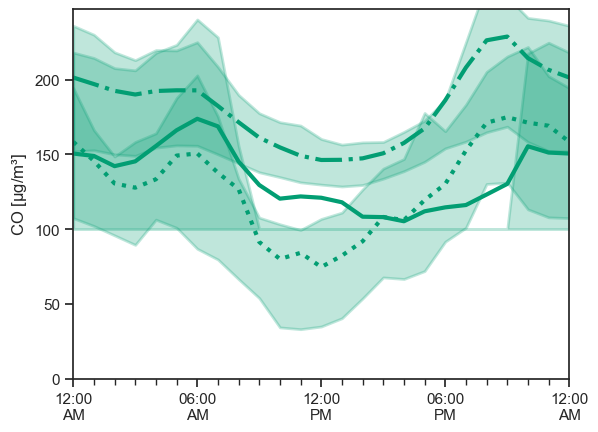

In [22]:
# Plot the diel trend
atmospy.dielplot(data=df,
    y="CO [ug/m3]", x="GMT",
    ylabel="$CO \; [μg/m³]$",
    plot_kws={"c": "g", "linestyle": "solid"},
    ylim=(0, None))

atmospy.dielplot(data=df,
    y="CO", x="GMT",
    ylabel="$CO \; [ug/m^3]$",
    plot_kws={"c": "g", "linestyle": "dotted"},
    ylim=(0, None))

atmospy.dielplot(data=df,
    y='carbon_monoxide (μg/m³)', x="GMT",
    ylabel="$CO \; [μg/m³]$",
    plot_kws={"c": "g", "linestyle": "dashdot"},
    ylim=(0, None))

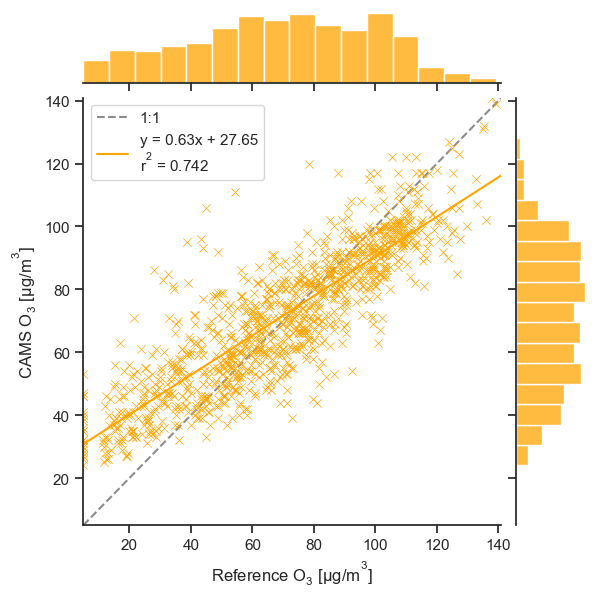

In [23]:
#df["ozone (μg/m³)"] = pd.to_numeric(df["ozone (μg/m³)"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="O3 [ug/m3]", 
    y="ozone (μg/m³)",   
    color="orange",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $O_{3}$ [$µg/m^{3}$]", ylabel="CAMS $O_{3}$ [$µg/m^{3}$]")

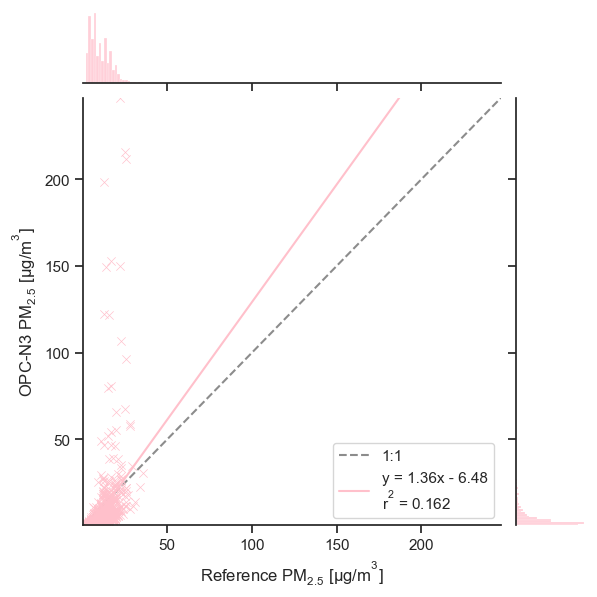

In [24]:
df["PM_2.5"] = pd.to_numeric(df["PM_2.5"], errors='coerce')

pm = atmospy.regplot(
    data=df,
    x="PM25 [ug/m3]", 
    y="PM_2.5",   
    color="pink",
    marker='x',
#    fit_reg=False
)
pm.set_axis_labels(xlabel="Reference $PM_{2.5}$ [$µg/m^{3}$]", ylabel="OPC-N3 $PM_{2.5}$ [$µg/m^{3}$]")

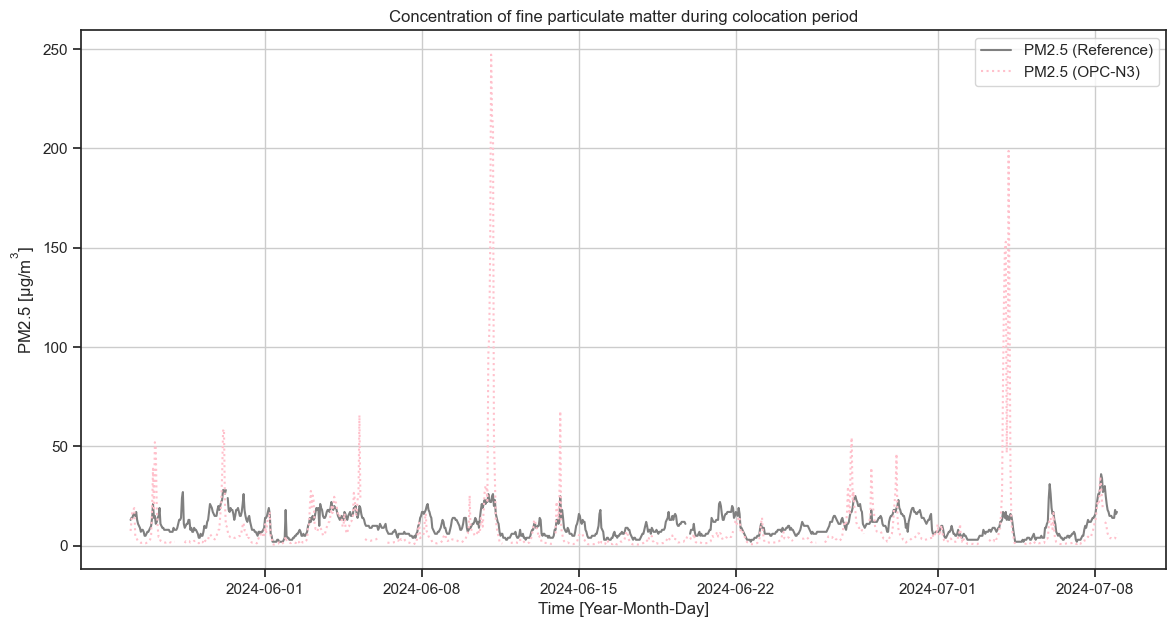

In [25]:
plt.figure(figsize=(14, 7))

plt.plot(df['GMT'], df['PM25 [ug/m3]'],  color="grey",label='PM2.5 (Reference)')
plt.plot(df['GMT'], df['PM_2.5'], color="pink", linestyle=":", label='PM2.5 (OPC-N3)')

plt.title('Concentration of fine particulate matter during colocation period')
plt.xlabel('Time [Year-Month-Day]')
plt.ylabel('PM2.5 [$µg/m^3$]')
plt.legend()
plt.grid(True)
plt.show()